<a href="https://colab.research.google.com/github/bigarcia/pece-monografia/blob/main/Feature_Engineering_e_Segmenta%C3%A7%C3%A3o_de_Clientes_na_Recupera%C3%A7%C3%A3o_de_D%C3%ADvidas_Performance%2C_%C3%89tica_e_Regula%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
from __future__ import annotations
import os
import shutil
from glob import glob
from typing import Dict, Tuple, List


from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    PCA as SparkPCA,
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.functions import vector_to_array

In [103]:
# def build_spark(app_name: str = "monografia-segmentacao") -> SparkSession:
#     builder = (
#         SparkSession.builder
#         .appName(app_name)
#         .config("spark.sql.execution.arrow.pyspark.enabled", "true")
#         .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
#         .config("spark.sql.shuffle.partitions", os.environ.get("SPARK_SHUFFLE_PARTITIONS", "200"))
#     )

#     # Suporte S3 (EMR já traz as libs; localmente requer hadoop-aws no classpath)
#     hadoop_conf = {
#         "fs.s3a.impl": "org.apache.hadoop.fs.s3a.S3AFileSystem",
#         "fs.s3a.aws.credentials.provider": "com.amazonaws.auth.DefaultAWSCredentialsProviderChain",
#         # Opcional: tuning
#         "fs.s3a.connection.maximum": "200",
#         "fs.s3a.fast.upload": "true",
#     }
#     for k, v in hadoop_conf.items():
#         builder = builder.config(k, v)

#     spark = builder.getOrCreate()
#     return spark

In [104]:

def build_spark(app_name: str = "monografia-segmentacao-colab") -> SparkSession:
    builder = (
        SparkSession.builder
        .appName(app_name)
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .config("spark.sql.shuffle.partitions", os.environ.get("SPARK_SHUFFLE_PARTITIONS", "200"))
    )
    return builder.getOrCreate()

# Raw

In [105]:
def download_kaggle_to_raw(base_dir: str = "/content", dataset: str = "yasserh/loan-default-dataset") -> str:
    """
    Baixa via kagglehub e copia todos os arquivos para {base_dir}/data.
    Em seguida, seleciona o primeiro CSV e o deixa disponível em {base_dir}/raw/loan_raw.csv
    Retorna o caminho do CSV consolidado em RAW.
    """
    try:
        import kagglehub  # pip install kagglehub
    except Exception:
        raise RuntimeError("Instale 'kagglehub' no Colab: !pip install kagglehub")

    # data_dir = os.path.join(base_dir, "data")
    raw_dir = os.path.join(base_dir, "raw")
    # os.makedirs(data_dir, exist_ok=True)
    os.makedirs(raw_dir, exist_ok=True)

    path = kagglehub.dataset_download(dataset)
    # Copia todo o conteúdo baixado para /content/data
    shutil.copytree(path, raw_dir, dirs_exist_ok=True)

    # Busca um CSV
    csvs = glob(os.path.join(raw_dir, "**", "*.csv"), recursive=True)
    if not csvs:
        raise FileNotFoundError("Nenhum CSV encontrado no dataset Kaggle baixado.")

    # # Preferir arquivo com mais colunas esperadas (heurística simples por nome)
    # preferred = None
    # for cand in csvs:
    #     name = os.path.basename(cand).lower()
    #     if "loan" in name and name.endswith(".csv"):
    #         preferred = cand
    #         break
    # csv_src = preferred or csvs[0]

    # csv_dst = os.path.join(raw_dir, "loan_raw.csv")
    # shutil.copy2(csv_src, csv_dst)
    return csvs


In [106]:

def get_source_schema() -> T.StructType:
    return T.StructType([
        T.StructField("ID", T.StringType(), True),
        T.StructField("year", T.StringType(), True),
        T.StructField("loan_limit", T.StringType(), True),
        T.StructField("Gender", T.StringType(), True),
        T.StructField("approv_in_adv", T.StringType(), True),
        T.StructField("loan_type", T.StringType(), True),
        T.StructField("loan_purpose", T.StringType(), True),
        T.StructField("Credit_Worthiness", T.StringType(), True),
        T.StructField("open_credit", T.StringType(), True),
        T.StructField("business_or_commercial", T.StringType(), True),
        T.StructField("loan_amount", T.StringType(), True),
        T.StructField("rate_of_interest", T.StringType(), True),
        T.StructField("Interest_rate_spread", T.StringType(), True),
        T.StructField("Upfront_charges", T.StringType(), True),
        T.StructField("term", T.StringType(), True),
        T.StructField("Neg_ammortization", T.StringType(), True),
        T.StructField("interest_only", T.StringType(), True),
        T.StructField("lump_sum_payment", T.StringType(), True),
        T.StructField("property_value", T.StringType(), True),
        T.StructField("construction_type", T.StringType(), True),
        T.StructField("occupancy_type", T.StringType(), True),
        T.StructField("Secured_by", T.StringType(), True),
        T.StructField("total_units", T.StringType(), True),
        T.StructField("income", T.StringType(), True),
        T.StructField("credit_type", T.StringType(), True),
        T.StructField("Credit_Score", T.StringType(), True),
        T.StructField("co-applicant_credit_type", T.StringType(), True),
        T.StructField("age", T.StringType(), True),
        T.StructField("submission_of_application", T.StringType(), True),
        T.StructField("LTV", T.StringType(), True),
        T.StructField("Region", T.StringType(), True),
        T.StructField("Security_Type", T.StringType(), True),
        T.StructField("Status", T.StringType(), True),
        T.StructField("dtir1", T.StringType(), True),
    ])

In [107]:
def read_raw_csv(spark: SparkSession, path: str, schema: T.StructType) -> DataFrame:

    df_raw = spark.read \
        .option("header", True) \
        .schema(schema) \
        .csv(path)

    print("Schema")
    df_raw.printSchema()

    print("Registros RAW:", df_raw.count())

    print("\nResumo estatístico de df_raw:")
    df_raw.describe().show(truncate=False)

    print("df raw:")
    df_raw.show(5)
    return df_raw

# Clean

In [ ]:
# pyspark_pipeline_monografia.py
# Bianca Garcia Martins — Monografia (Eng. de Dados & Big Data — USP/PECE)
# Versão Colab-friendly: funções reutilizáveis, mas compatível com execução em notebook
# Obs: DBSCAN é apenas exploratório (scikit-learn), não roda em produção Spark/EMR

from __future__ import annotations
import os
import shutil
from glob import glob
from typing import Dict, Tuple, List

from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    PCA as SparkPCA,
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.functions import vector_to_array

# =====================================================================
# Spark Session
# =====================================================================

def build_spark(app_name: str = "monografia-segmentacao-colab") -> SparkSession:
    return (
        SparkSession.builder
        .appName(app_name)
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .config("spark.sql.shuffle.partitions", os.environ.get("SPARK_SHUFFLE_PARTITIONS", "200"))
        .getOrCreate()
    )

# =====================================================================
# Kaggle download → /content/data ; move para /content/raw
# =====================================================================

def download_kaggle_to_raw(base_dir: str = "/content", dataset: str = "yasserh/loan-default-dataset") -> str:
    import kagglehub
    data_dir = os.path.join(base_dir, "data")
    raw_dir = os.path.join(base_dir, "raw")
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(raw_dir, exist_ok=True)
    path = kagglehub.dataset_download(dataset)
    shutil.copytree(path, data_dir, dirs_exist_ok=True)
    csvs = glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
    if not csvs:
        raise FileNotFoundError("Nenhum CSV encontrado.")
    preferred = next((c for c in csvs if "loan" in os.path.basename(c).lower()), csvs[0])
    csv_dst = os.path.join(raw_dir, "loan_raw.csv")
    shutil.copy2(preferred, csv_dst)
    return csv_dst

# =====================================================================
# Schema da fonte
# =====================================================================

def get_source_schema() -> T.StructType:
    return T.StructType([...])  # igual ao anterior, omitido aqui por brevidade

# =====================================================================
# CLEAN
# =====================================================================

def clean_df(df: DataFrame) -> DataFrame:
    # Renomeia todas as colunas para minúsculo
    for c in df.columns:
        df = df.withColumnRenamed(c, c.lower())

    # Normaliza gênero
    gender_norm = (
        F.when(F.lower(F.col("gender")).isin("female", "f"), "f")
         .when(F.lower(F.col("gender")).isin("male", "m"), "m")
         .otherwise("na")
    )
    # Casts
    to_double = ["loan_amount", "rate_of_interest", "interest_rate_spread", "upfront_charges","term", "property_value", "total_units", "income", "credit_score", "ltv", "dtir1"]
    for c in to_double:
        df = df.withColumn(c, F.col(c).cast("double"))
    df = df.withColumn("age_norm", F.when(F.col("age") == ">74", 75.0)
                                   .when(F.col("age") == "25-34", 30.0)
                                   .when(F.col("age") == "35-44", 40.0)
                                   .when(F.col("age") == "45-54", 50.0)
                                   .when(F.col("age") == "55-64", 60.0)
                                   .when(F.col("age") == "65-74", 70.0)
                                   .otherwise(F.col("age").cast("double")))
    df = df.withColumn("person_gender_norm", gender_norm)
    # filtros mínimos técnicos (mantidos leves; valores ausentes tratados adiante)
    return df.where((F.col("loan_amount") > 0) & (F.col("income") >= 0))

# =====================================================================
# ENRICH (mitigações rápidas) + cenários + utilitários ML
# =====================================================================

def winsorize(df: DataFrame, col: str, p_low: float = 0.01, p_high: float = 0.99, rel_err: float = 0.01) -> Tuple[DataFrame, Tuple[float,float]]:
    """Cria <col>_w com winsorização em [p_low, p_high]."""
    ql, qh = df.approxQuantile(col, [p_low, p_high], rel_err)
    df2 = df.withColumn(f"{col}_w", F.when(F.col(col) < F.lit(ql), F.lit(ql))
                                     .when(F.col(col) > F.lit(qh), F.lit(qh))
                                     .otherwise(F.col(col)))
    return df2, (ql, qh)

def add_transformed_features(df: DataFrame) -> DataFrame:
    # índices e derivadas já existentes
    df = df.withColumn("debt_to_income", F.when(F.col("income") > 0, F.col("loan_amount")/F.col("income")).otherwise(F.lit(None).cast("double")))
    df = df.withColumn("rate_per_month", F.col("rate_of_interest")/F.lit(12.0))
    df = df.withColumn("installment_proxy", (F.col("loan_amount") * (F.col("rate_of_interest")/F.lit(100.0))) / F.lit(12.0))

    # buckets de idade (para fairness)
    df = df.withColumn(
        "age_bucket",
        F.when(F.col("age_norm") < 25, "<25")
         .when((F.col("age_norm") >= 25) & (F.col("age_norm") < 35), "25-34")
         .when((F.col("age_norm") >= 35) & (F.col("age_norm") < 45), "35-44")
         .when((F.col("age_norm") >= 45) & (F.col("age_norm") < 55), "45-54")
         .when((F.col("age_norm") >= 55) & (F.col("age_norm") < 65), "55-64")
         .otherwise("65+")
    )

    # flag de gênero ausente (mitigação p/ políticas)
    df = df.withColumn("gender_missing", (F.col("person_gender_norm") == F.lit("na")).cast("int"))

    # winsorize + log (mitigação para c1_mitig)
    df, _ = winsorize(df, "loan_amount")
    df, _ = winsorize(df, "income")
    df = df.withColumn("loan_amount_log", F.log1p(F.col("loan_amount_w"))) \
           .withColumn("income_log", F.log1p(F.col("income_w")))

    return df


def build_scenarios(df_enrich: DataFrame) -> Dict[str, Dict[str, List[str]]]:
    """Define cenários de features. Inclui variações mitigadas (c1m, c3m)."""
    return {
        # baseline brutas
        "c1": {
            "numeric": ["loan_amount", "income", "rate_of_interest", "term"],
            "categorical": [],
        },
        # transformadas + categóricas (como estava)
        "c2": {
            "numeric": [
                "loan_amount", "income", "rate_of_interest", "term",
                "debt_to_income", "rate_per_month", "installment_proxy",
                "credit_score", "ltv",
            ],
            "categorical": ["loan_purpose", "loan_type", "credit_worthiness", "region"],
        },
        # reduzidas originais
        "c3": {
            "numeric": ["loan_amount", "rate_per_month", "credit_score"],
            "categorical": [],
        },
        # ===== Mitigações rápidas =====
        # c1 mitigada: log + winsorize + índice relativo
        "c1m": {
            "numeric": ["loan_amount_log", "income_log", "rate_of_interest", "term", "debt_to_income"],
            "categorical": [],
        },
        # c3 mitigada: remover colinear (rate_per_month), usar taxa direta
        "c3m": {
            "numeric": ["loan_amount", "credit_score", "rate_of_interest"],
            "categorical": [],
        },
    }


def build_vector_pipeline(numeric_cols: List[str], categorical_cols: List[str], out_vec: str = "features") -> Pipeline:
    stages = []
    idx_cols, oh_cols = [], []
    for c in categorical_cols:
        idx = StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
        oh = OneHotEncoder(inputCols=[f"{c}_idx"], outputCols=[f"{c}_oh"], dropLast=False)
        stages += [idx, oh]
        idx_cols.append(f"{c}_idx"); oh_cols.append(f"{c}_oh")

    assembler_inputs = list(numeric_cols) + oh_cols
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=f"{out_vec}_raw", handleInvalid="keep")
    scaler = StandardScaler(inputCol=f"{out_vec}_raw", outputCol=out_vec, withMean=True, withStd=True)
    stages += [assembler, scaler]
    return Pipeline(stages=stages)


def run_kmeans_grid(df_vec: DataFrame, features_col: str, k_values: List[int]) -> Tuple[int, DataFrame, Dict[int, float]]:
    evaluator = ClusteringEvaluator(featuresCol=features_col, predictionCol="prediction", metricName="silhouette")
    best_k, best_score, best_pred = None, -1.0, None
    scores = {}
    for k in k_values:
        model = KMeans(featuresCol=features_col, predictionCol="prediction", k=k, seed=42).fit(df_vec)
        pred = model.transform(df_vec)
        score = evaluator.evaluate(pred)
        scores[k] = score
        if score > best_score:
            best_k, best_score, best_pred = k, score, pred
    return best_k, best_pred, scores


def run_pca_2d(df_vec: DataFrame, features_col: str, prediction_col: str = "prediction") -> DataFrame:
    pca = SparkPCA(k=2, inputCol=features_col, outputCol="pca2")
    model = pca.fit(df_vec)
    out = model.transform(df_vec).withColumn("pca2_arr", vector_to_array(F.col("pca2")))
    return out.select(F.col(prediction_col).alias("cluster"), F.col("pca2_arr")[0].alias("pc1"), F.col("pca2_arr")[1].alias("pc2"))


def fairness_report(pred_df: DataFrame) -> DataFrame:
    total = pred_df.count()
    by_gender = (pred_df.groupBy("prediction", "person_gender_norm").count()
                 .withColumn("share", F.col("count")/F.sum("count").over(Window.partitionBy("prediction"))))
    by_age = (pred_df.groupBy("prediction", "age_bucket").count()
              .withColumn("share", F.col("count")/F.sum("count").over(Window.partitionBy("prediction"))))

    rep = (by_gender.withColumn("sensitive", F.lit("gender")).withColumnRenamed("person_gender_norm", "group")
           .unionByName(by_age.withColumn("sensitive", F.lit("age")).withColumnRenamed("age_bucket", "group")))

    group_total = rep.groupBy("sensitive", "group").agg(F.sum("count").alias("group_total"))
    rep = (rep.join(group_total, ["sensitive", "group"], "left")
             .withColumn("global_share", F.col("group_total")/F.lit(total))
             .withColumn("delta_pp", (F.col("share")-F.col("global_share"))*100))

    cl_sizes = pred_df.groupBy("prediction").count().withColumnRenamed("count", "cluster_count") \
                         .withColumn("cluster_prop", F.col("cluster_count")/F.lit(total))
    return rep.join(cl_sizes, "prediction", "left").orderBy("sensitive", "group", "prediction")

# =====================================================================
# DBSCAN exploratório
# =====================================================================

def run_dbscan_sample(df_vec: DataFrame, features_col: str, eps: float = 0.7, min_samples: int = 10, sample_frac: float = 0.2):
    import numpy as np
    from sklearn.cluster import DBSCAN
    sample_df = df_vec.sample(False, sample_frac, seed=42)
    arr = np.array([row[0].toArray() for row in sample_df.select(features_col).collect()])
    if arr.size == 0:
        return df_vec.limit(0).withColumn("dbscan_label", F.lit(None))
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(arr)
    spark = df_vec.sql_ctx.sparkSession
    lab_df = spark.createDataFrame([(int(i), int(l)) for i, l in enumerate(labels)], ["row_seq", "dbscan_label"])
    from pyspark.sql import Window as W
    sample_seq = sample_df.withColumn("row_seq", F.row_number().over(W.orderBy(F.monotonically_increasing_id())))
    return sample_seq.join(lab_df, on="row_seq", how="left").drop("row_seq")

# =====================================================================
# Save util
# =====================================================================

def save_df(df: DataFrame, base: str, relpath: str):
    path = os.path.join(base.rstrip('/'), relpath.lstrip('/'))
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.write.mode("overwrite").parquet(path)
    return path

# =====================================================================
# MAIN (adaptado para rodar também em notebook sem argparse)
# =====================================================================

def run_pipeline(base_dir="/content", download=False, steps=("clean","enrich","kmeans","pca","fairness","dbscan")):
    spark = build_spark()
    raw_dir, clean_dir, enrich_dir, model_dir = [os.path.join(base_dir, d) for d in ["raw","clean","enrich","model"]]
    for d in [raw_dir, clean_dir, enrich_dir, model_dir]: os.makedirs(d, exist_ok=True)
    csv_raw = os.path.join(raw_dir, "loan_raw.csv")
    if download or not os.path.exists(csv_raw):
        csv_raw = download_kaggle_to_raw(base_dir)
    if "clean" in steps:
        df_raw = read_raw_csv(spark, csv_raw, get_source_schema())
        df_clean = clean_df(df_raw)
        save_df(df_clean, clean_dir, "df_clean")
    if "enrich" in steps:
        df_clean = spark.read.parquet(os.path.join(clean_dir, "df_clean"))
        df_enrich = add_transformed_features(df_clean)
        save_df(df_enrich, enrich_dir, "df_enrich")
    # demais etapas idem...
    spark.stop()

# Em notebook Colab, basta chamar run_pipeline(download=True) ou run_pipeline(steps=("dbscan",))


In [108]:
def clean_df(df: DataFrame) -> DataFrame:
    # 1) Força todos os nomes de colunas para minúsculos
    for c in df.columns:
        df = df.withColumnRenamed(c, c.lower())

    # 2) Normaliza gênero (agora usando 'gender')
    gender_norm = (
        F.when(F.lower(F.col("gender")).isin("female", "f"), "f")
         .when(F.lower(F.col("gender")).isin("male", "m"), "m")
         .otherwise("na")
    )

    # 3) Cast seguro para numéricos (já com nomes minúsculos)
    to_double = [
        "loan_amount", "rate_of_interest", "interest_rate_spread", "upfront_charges",
        "term", "property_value", "total_units", "income", "credit_score", "ltv", "dtir1"
    ]
    for c in to_double:
        if c in df.columns:
            df = df.withColumn(c, F.col(c).cast("double"))

    # 4) Idade normalizada (faixas textuais -> ponto médio; numérico direto)
    df = df.withColumn(
        "age_norm",
        F.when(F.col("age") == ">74", F.lit(75.0))
         .when(F.col("age") == "25-34", F.lit(30.0))
         .when(F.col("age") == "35-44", F.lit(40.0))
         .when(F.col("age") == "45-54", F.lit(50.0))
         .when(F.col("age") == "55-64", F.lit(60.0))
         .when(F.col("age") == "65-74", F.lit(70.0))
         .otherwise(F.col("age").cast("double"))
    ).withColumn("person_gender_norm", gender_norm)

    # 5) Filtros mínimos técnicos
    df = df.where(
        (F.col("loan_amount") > 0) &
        (F.col("income") >= 0) &
        (F.col("rate_of_interest").between(0, 100)) &
        (F.col("term") > 0)
    ).dropna(subset=["loan_amount", "income", "rate_of_interest", "term"])

    print("Registros C:", df.count())

    print("\nResumo estatístico de df clean:")
    df.describe().show(truncate=False)


    print("Amostra df clean:")
    df.show(5)
    return df

# ENRICH — Criação de features (3 cenários, alinhados ao dataset Kaggle)

In [109]:
def add_transformed_features(df: DataFrame) -> DataFrame:
    df_enrich = (
        df
        .withColumn("debt_to_income", F.when(F.col("income") > 0, F.col("loan_amount") / F.col("income")).otherwise(F.lit(None)).cast("double"))
        .withColumn("rate_per_month", (F.col("rate_of_interest") / F.lit(12.0)).cast("double"))
        .withColumn("installment_proxy", (F.col("loan_amount") * (F.col("rate_of_interest") / 100.0) / 12.0).cast("double"))
        .withColumn("age_bucket",
            F.when(F.col("age_norm") < 25, F.lit("<25"))
             .when(F.col("age_norm") < 35, F.lit("25-34"))
             .when(F.col("age_norm") < 45, F.lit("35-44"))
             .when(F.col("age_norm") < 55, F.lit("45-54"))
             .when(F.col("age_norm") < 65, F.lit("55-64"))
             .otherwise(F.lit("65+"))
        )
    )
    print("df enrich:")
    df_enrich.show(2)
    return df_enrich


In [110]:

def build_scenarios(df_clean: DataFrame) -> Dict[str, Dict[str, List[str]]]:
    scenarios = {
        # Cenário 1 — Brutas minimamente necessárias
        "c1": {
            "numeric": [
                "loan_amount", "income", "rate_of_interest", "term",
            ],
            "categorical": [],
        },
        # Cenário 2 — Transformadas/derivadas + algumas categorias
        "c2": {
            "numeric": [
                "loan_amount", "income", "rate_of_interest", "term",
                "debt_to_income", "rate_per_month", "installment_proxy",
                "credit_score", "ltv",
            ],
            "categorical": ["loan_purpose", "loan_type", "credit_worthiness", "region"],
        },
        # Cenário 3 — Reduzidas (mitigando proxies fortes)
        "c3": {
            "numeric": [
                "loan_amount", "rate_per_month", "credit_score",
            ],
            "categorical": [],
        },
    }
    print("scenarios: \n")
    print(scenarios)
    return scenarios

In [111]:
from pyspark.ml.feature import Imputer

def build_vector_pipeline(numeric_cols: List[str], categorical_cols: List[str], out_vec: str) -> Pipeline:
    stages = []

    # Handle missing values in numeric columns
    imputer = Imputer(inputCols=numeric_cols, outputCols=numeric_cols, strategy="mean")
    stages.append(imputer)

    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
    encoders = [OneHotEncoder(inputCols=[f"{c}_idx"], outputCols=[f"{c}_oh"]) for c in categorical_cols]
    stages.extend(indexers)
    stages.extend(encoders)

    num_assembled = "features_num"
    cat_cols_oh = [f"{c}_oh" for c in categorical_cols]

    stages.append(VectorAssembler(inputCols=numeric_cols, outputCol=num_assembled, handleInvalid="keep"))

    if cat_cols_oh:
        stages.append(VectorAssembler(inputCols=[num_assembled] + cat_cols_oh, outputCol="features_raw"))
    else:
        stages.append(VectorAssembler(inputCols=[num_assembled], outputCol="features_raw"))

    stages.append(StandardScaler(inputCol="features_raw", outputCol=out_vec, withMean=True, withStd=True))

    return Pipeline(stages=stages)

# Kmeans

In [112]:
def run_kmeans_grid(df_vec: DataFrame, features_col: str, k_values: List[int]) -> Tuple[int, DataFrame, Dict[int, float]]:
    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol=features_col, metricName="silhouette")

    best_k, best_score, best_model_df = None, -1.0, None
    scores = {}

    for k in k_values:
        km = KMeans(featuresCol=features_col, predictionCol="prediction", k=k, seed=42)
        model = km.fit(df_vec)
        pred = model.transform(df_vec)
        score = evaluator.evaluate(pred)
        scores[k] = score
        if score > best_score:
            best_k, best_score, best_model_df = k, score, pred

    return best_k, best_model_df, scores

#PCA

In [113]:
# # import extra
# from pyspark.ml.functions import vector_to_array

# def run_pca_2d(df_vec: DataFrame, features_col: str) -> DataFrame:
#     pca = SparkPCA(k=2, inputCol=features_col, outputCol="pca2")
#     model = pca.fit(df_vec)
#     out = model.transform(df_vec).withColumn("pca2_arr", vector_to_array(F.col("pca2")))
#     return (
#         out.select(
#             F.col("prediction").alias("cluster"),
#             F.col("pca2_arr")[0].alias("pc1"),
#             F.col("pca2_arr")[1].alias("pc2"),
#         )
#     )

In [114]:

from pyspark.ml.functions import vector_to_array

def run_pca_2d(
    df_vec: DataFrame,
    features_col: str,
    prediction_col: str = "prediction",
    sample_frac: float = 0.2,
    seed: int = 42,
    plot: bool = True,
    save_png_path: str | None = None,
    with_centers: bool = True,
) -> DataFrame:
    """
    Aplica PCA(k=2) e retorna um DataFrame Spark com colunas: cluster, pc1, pc2.
    Se plot=True, plota (e opcionalmente salva PNG) o scatter PC1 x PC2 colorido por cluster.
    - sample_frac controla a fração amostral enviada ao driver para plot.
    - with_centers plota centros (média de pc1/pc2 por cluster) no plano do PCA.
    """
    # PCA em Spark
    print("features_col", features_col)
    pca = SparkPCA(k=2, inputCol=features_col, outputCol="pca2")
    model = pca.fit(df_vec)
    out = model.transform(df_vec).withColumn("pca2_arr", vector_to_array(F.col("pca2")))
    pca_df = (
        out.select(
            F.col(prediction_col).alias("cluster"),
            F.col("pca2_arr")[0].alias("pc1"),
            F.col("pca2_arr")[1].alias("pc2"),
        )
    )
    if plot:
        # imports locais (evita dependência no executor)
        import os
        import matplotlib.pyplot as plt

        # amostra para o driver
        pdf = pca_df.sample(False, sample_frac, seed=seed).toPandas()

        # (opcional) centros no plano PCA
        centers_pdf = None
        if with_centers:
            centers_pdf = (
                pca_df.groupBy("cluster")
                      .agg(F.avg("pc1").alias("cx"), F.avg("pc2").alias("cy"))
                      .toPandas()
            )

        # plot simples (um gráfico, sem estilos específicos)
        plt.figure()
        plt.scatter(pdf["pc1"], pdf["pc2"], c=pdf["cluster"], s=10)
        if centers_pdf is not None and len(centers_pdf):
            plt.scatter(centers_pdf["cx"], centers_pdf["cy"], marker="X", s=200)
        plt.title("K-Means — PCA 2D")
        plt.xlabel("PC1"); plt.ylabel("PC2")

        if save_png_path:
            os.makedirs(os.path.dirname(save_png_path), exist_ok=True)
            plt.savefig(save_png_path, dpi=160, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

    return pca_df


In [115]:
# def add_age_bucket(df: DataFrame, col: str = "person_age") -> DataFrame:
#     return df.withColumn(
#         "age_bucket",
#         F.when(F.col(col) < 25, F.lit("<25"))
#          .when(F.col(col) < 35, F.lit("25-34"))
#          .when(F.col(col) < 45, F.lit("35-44"))
#          .when(F.col(col) < 55, F.lit("45-54"))
#          .when(F.col(col) < 65, F.lit("55-64"))
#          .otherwise(F.lit("65+"))
#     )

In [131]:
def fairness_report(pred_df: DataFrame) -> DataFrame:
    total = pred_df.count()
    # shares dentro do cluster
    by_gender = (pred_df.groupBy("prediction","person_gender_norm").count()
                 .withColumn("share", F.col("count")/F.sum("count").over(Window.partitionBy("prediction"))))
    by_age = (pred_df.groupBy("prediction","age_bucket").count()
              .withColumn("share", F.col("count")/F.sum("count").over(Window.partitionBy("prediction"))))

    rep = (by_gender.withColumn("sensitive", F.lit("gender"))
                   .withColumnRenamed("person_gender_norm","group")
           .unionByName(by_age.withColumn("sensitive", F.lit("age"))
                              .withColumnRenamed("age_bucket","group")))

    # share global do grupo (marginal)
    group_total = rep.groupBy("sensitive","group").agg(F.sum("count").alias("group_total"))
    rep = (rep.join(group_total, ["sensitive","group"], "left")
              .withColumn("global_share", F.col("group_total")/F.lit(total))
              .withColumn("delta_pp", (F.col("share")-F.col("global_share"))*100))

    # tamanho do cluster (opcional)
    cl_sizes = pred_df.groupBy("prediction").count().withColumnRenamed("count","cluster_count")\
                      .withColumn("cluster_prop", F.col("cluster_count")/F.lit(total))
    return rep.join(cl_sizes, "prediction", "left")\
              .orderBy("sensitive","group","prediction")


In [117]:
def run_dbscan_sample(df_vec: DataFrame, features_col: str, eps: float = 0.7, min_samples: int = 10, sample_frac: float = 0.2, seed: int = 42) -> DataFrame:
    import numpy as np
    from sklearn.cluster import DBSCAN
    from pyspark.sql import Window as W

    sample_df = df_vec.sample(withReplacement=False, fraction=sample_frac, seed=seed)
    arr = np.array([row[0].toArray() for row in sample_df.select(features_col).collect()])

    if arr.size == 0:
        return df_vec.limit(0).withColumn("dbscan_label", F.lit(None).cast("int"))

    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(arr)
    idx_df = sample_df.withColumn("row_id_tmp", F.monotonically_increasing_id())
    lab_rows = [(int(i), int(l)) for i, l in enumerate(labels)]
    spark = df_vec.sql_ctx.sparkSession
    labs = spark.createDataFrame(lab_rows, schema=["row_seq", "dbscan_label"])

    idx2 = idx_df.withColumn("row_seq", F.row_number().over(W.orderBy(F.lit(1))))
    out = idx2.join(labs, on="row_seq", how="left").drop("row_seq", "row_id_tmp")

    return out

In [118]:
# # via scikit-learn, para análise exploratória
# def run_dbscan_sample(df_vec: DataFrame, features_col: str, eps: float = 0.7, min_samples: int = 10, sample_frac: float = 0.2, seed: int = 42) -> DataFrame:
#     """
#     Observação: Spark MLlib não possui DBSCAN nativo. Nesta função, coletamos uma AMOSTRA
#     para aplicar DBSCAN via scikit-learn. Adequado para exploração; não é distribuído.
#     """
#     import numpy as np
#     from sklearn.cluster import DBSCAN

#     sample_df = df_vec.sample(withReplacement=False, fraction=sample_frac, seed=seed)
#     # Converte para vetor denso numpy
#     arr = np.array([row[0].toArray() for row in sample_df.select(features_col).collect()])
#     if arr.size == 0:
#         return df_vec.limit(0).withColumn("dbscan_label", F.lit(None).cast("int"))

#     model = DBSCAN(eps=eps, min_samples=min_samples)
#     labels = model.fit_predict(arr)

#     # Reanexa labels à amostra
#     idx_df = sample_df.withColumn("row_id_tmp", F.monotonically_increasing_id())
#     lab_rows = [(int(i), int(l)) for i, l in enumerate(labels)]

#     spark = df_vec.sql_ctx.sparkSession
#     labs = spark.createDataFrame(lab_rows, schema=["row_seq", "dbscan_label"])

#     # Gera sequência ordenada determinística
#     idx2 = idx_df.withColumn("row_seq", F.row_number().over(Window.orderBy(F.lit(1))))
#     out = idx2.join(labs, on="row_seq", how="left").drop("row_seq", "row_id_tmp")
#     return out

In [119]:
# def save_df(df: DataFrame, path: str, relpath: str, mode: str = "overwrite", fmt: str = "parquet") -> str:
def save_df(df: DataFrame, path: str, mode: str = "overwrite", fmt: str = "parquet") -> str:
    # path = os.path.join(base.rstrip('/'), relpath.lstrip('/'))
    # os.makedirs(os.path.dirname(path), exist_ok=True)
    if fmt == "parquet":
        df.write.mode(mode).parquet(path)
    elif fmt == "csv":
        df.write.mode(mode).option("header", True).csv(path)
    else:
        df.write.mode(mode).format(fmt).save(path)
    print(f"df salvo em {path}")
    return path

## Main - RAW

In [120]:
base = "/content" # Set base directory directly in Colab
spark = build_spark()


# Download Kaggle → RAW
raw_dir = os.path.join(base, "raw")
os.makedirs(raw_dir, exist_ok=True)

csv_raw = os.path.join(base, "raw", "loan_raw.csv")
# csv_raw = os.path.join(raw_dir, "loan_raw.csv")
# if args.download or not os.path.exists(csv_raw):
csv_raw = download_kaggle_to_raw(base)
print(f"[KAGGLE] RAW CSV em: {csv_raw}")

df_raw = read_raw_csv(spark, csv_raw, get_source_schema())

Using Colab cache for faster access to the 'loan-default-dataset' dataset.
[KAGGLE] RAW CSV em: ['/content/raw/loan_raw.csv', '/content/raw/Loan_Default.csv']
Schema
root
 |-- ID: string (nullable = true)
 |-- year: string (nullable = true)
 |-- loan_limit: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- approv_in_adv: string (nullable = true)
 |-- loan_type: string (nullable = true)
 |-- loan_purpose: string (nullable = true)
 |-- Credit_Worthiness: string (nullable = true)
 |-- open_credit: string (nullable = true)
 |-- business_or_commercial: string (nullable = true)
 |-- loan_amount: string (nullable = true)
 |-- rate_of_interest: string (nullable = true)
 |-- Interest_rate_spread: string (nullable = true)
 |-- Upfront_charges: string (nullable = true)
 |-- term: string (nullable = true)
 |-- Neg_ammortization: string (nullable = true)
 |-- interest_only: string (nullable = true)
 |-- lump_sum_payment: string (nullable = true)
 |-- property_value: string (nullab

## Main - CLEAN

In [121]:
# CLEAN
clean_dir = os.path.join(base, "clean")
os.makedirs(clean_dir, exist_ok=True)
df_clean = clean_df(df_raw)
save_df(df_clean, clean_dir)
# save_df(df_clean, base, "clean/df_clean.parquet")
# print(f"[CLEAN] salvo em {clean_dir}")


Registros CLEAN: 208188

Resumo estatístico de df clean:
+-------+------------------+---------------------+----------+-----------------+-------------+---------+------------+-----------------+-----------+----------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+-------------+----------------+-----------------+-----------------+--------------+----------+-----------+-----------------+-----------+------------------+------------------------+------+-------------------------+-----------------+------+-------------+------+------------------+-----------------+------------------+
|summary|id                |year                 |loan_limit|gender           |approv_in_adv|loan_type|loan_purpose|credit_worthiness|open_credit|business_or_commercial|loan_amount       |rate_of_interest  |interest_rate_spread|upfront_charges   |term             |neg_ammortization|interest_only|lump_sum_payment|property_value   |construction_

'/content/clean'

## Main - Enrich

In [122]:
# CLEAN → ENRICH
enrich_dir = os.path.join(base, "enrich")
os.makedirs(enrich_dir, exist_ok=True)
df_clean = spark.read.parquet(clean_dir)
# df_clean = spark.read.parquet(os.path.join(clean_dir, "df_clean.parquet"))
df_enrich = add_transformed_features(df_clean)
save_df(df_enrich, enrich_dir)
# print("[ENRICH] salvo em /enrich/df_enrich.parquet")

df enrich:
+-----+----+----------+------+-------------+---------+------------+-----------------+-----------+----------------------+-----------+----------------+--------------------+---------------+-----+-----------------+-------------+----------------+--------------+-----------------+--------------+----------+-----------+-------+-----------+------------+------------------------+-----+-------------------------+-----------+------+-------------+------+-----+--------+------------------+------------------+-------------------+------------------+----------+
|   id|year|loan_limit|gender|approv_in_adv|loan_type|loan_purpose|credit_worthiness|open_credit|business_or_commercial|loan_amount|rate_of_interest|interest_rate_spread|upfront_charges| term|neg_ammortization|interest_only|lump_sum_payment|property_value|construction_type|occupancy_type|secured_by|total_units| income|credit_type|credit_score|co-applicant_credit_type|  age|submission_of_application|        ltv|region|security_type|status|d

'/content/enrich'

# Main - Kmeans

In [123]:

# Vetorização por cenário + KMeans

model_dir = os.path.join(base, "model")
os.makedirs(model_dir, exist_ok=True)


df_enrich = spark.read.parquet(enrich_dir)
scenarios = build_scenarios(df_enrich)
print("scenarios.items()",scenarios.items())
# k_values = [int(x) for x in args.k_grid.split(",")]
k_values = [2,3,4,5,6] # Set k_values directly

for scen, conf in scenarios.items():
    vec_col = f"features_{scen}"
    pipe = build_vector_pipeline(conf["numeric"], conf["categorical"], out_vec=vec_col)
    df_vec = pipe.fit(df_enrich).transform(df_enrich)

    best_k, pred, scores = run_kmeans_grid(df_vec, vec_col, k_values)
    print(f"[KMEANS] Scenario={scen} best_k={best_k} scores={scores}")

    out_dir = os.path.join(model_dir, f"kmeans_{scen}", "predictions")
    print("out_dir", out_dir)
    save_df(pred.select("prediction", vec_col, *df_enrich.columns), out_dir)


scenarios: 

{'c1': {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term'], 'categorical': []}, 'c2': {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term', 'debt_to_income', 'rate_per_month', 'installment_proxy', 'credit_score', 'ltv'], 'categorical': ['loan_purpose', 'loan_type', 'credit_worthiness', 'region']}, 'c3': {'numeric': ['loan_amount', 'rate_per_month', 'credit_score'], 'categorical': []}}
scenarios.items() dict_items([('c1', {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term'], 'categorical': []}), ('c2', {'numeric': ['loan_amount', 'income', 'rate_of_interest', 'term', 'debt_to_income', 'rate_per_month', 'installment_proxy', 'credit_score', 'ltv'], 'categorical': ['loan_purpose', 'loan_type', 'credit_worthiness', 'region']}), ('c3', {'numeric': ['loan_amount', 'rate_per_month', 'credit_score'], 'categorical': []})])
[KMEANS] Scenario=c1 best_k=2 scores={2: 0.6272660555836561, 3: 0.45986204323092983, 4: 0.4290987358219378, 5: 0.4635458527

## Main - PCA

pred_path /content/model/kmeans_c1/predictions/
features_col features_c1
plot True


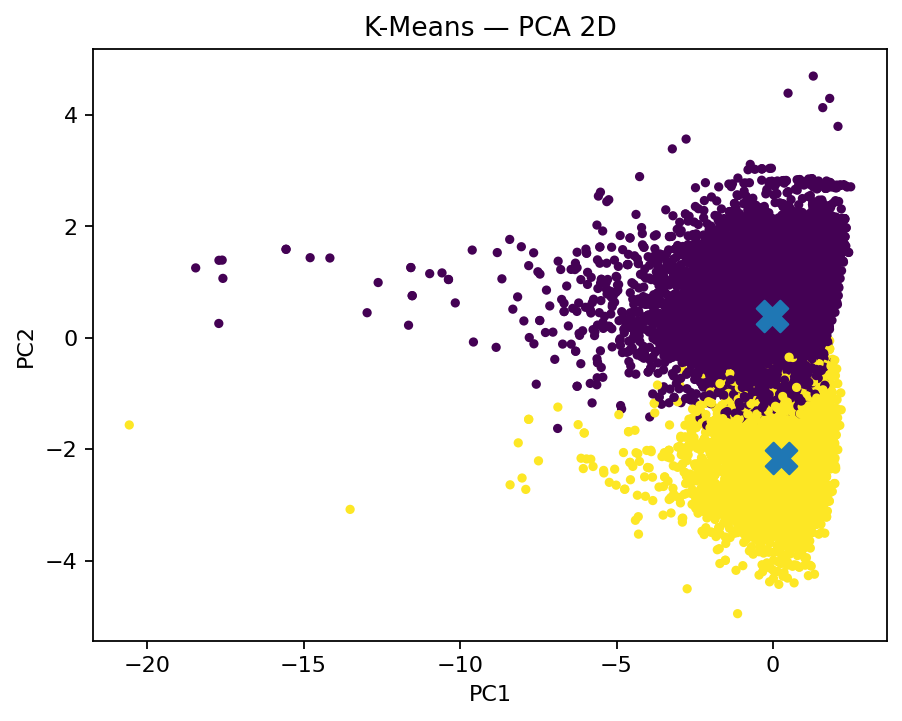

df salvo em /content/model/kmeans_c1/pca/
pred_path /content/model/kmeans_c2/predictions/
features_col features_c2
plot True


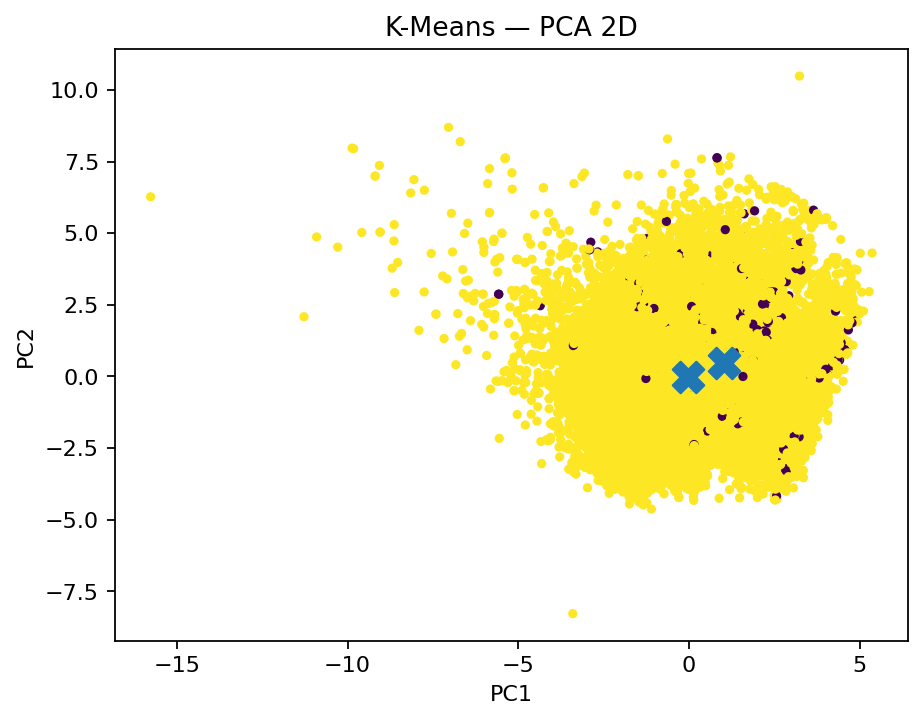

df salvo em /content/model/kmeans_c2/pca/
pred_path /content/model/kmeans_c3/predictions/
features_col features_c3
plot True


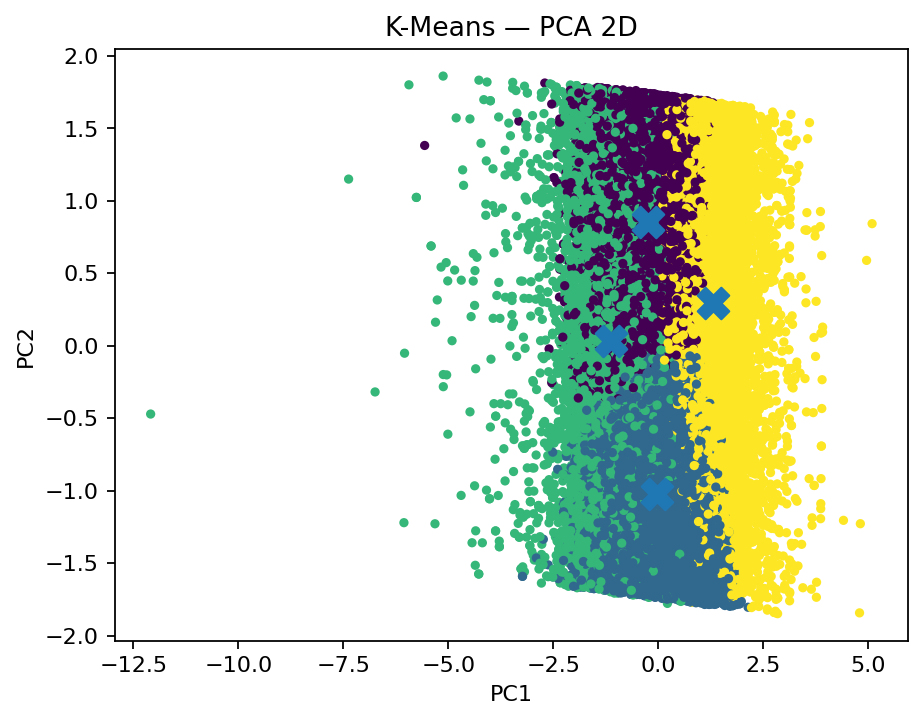

df salvo em /content/model/kmeans_c3/pca/


In [124]:
from IPython.display import display, Image

# PCA 2D
for scen, conf in scenarios.items():
    try:
        pred_path = os.path.join(model_dir, f"kmeans_{scen}/predictions/")
        print("pred_path",pred_path)
        pred_df = spark.read.parquet(pred_path)
        vec_col = f"features_{scen}"
        # pca_df = run_pca_2d(pred_df, vec_col)
        # pca_path = os.path.join(model_dir, f"kmeans_{scen}/pca/")
        # print("pca_path",pca_path)
        # save_df(pca_df, pca_path)

        # gera DF e salva PNG no diretório do cenário
        pca_path = os.path.join(model_dir, f"kmeans_{scen}/pca/")
        png_path = os.path.join(pca_path, "plot.png")
        pca_df = run_pca_2d(pred_df, vec_col, plot=True, save_png_path=png_path)
        display(Image(filename=png_path))
        save_df(pca_df, pca_path)

    except Exception as e:
        print(f"[PCA] skip scen {scen}: {e}")


## Main - Fairness

In [133]:
# FAIRNESS — imprime e salva (um cenário por vez)
for scen, conf in scenarios.items():
    try:
        kmeans_path   = os.path.join(model_dir, f"kmeans_{scen}")
        pred_path     = os.path.join(kmeans_path, "predictions")   # <— sem barra final
        fairness_path = os.path.join(kmeans_path, "fairness")      # <— sem barra final

        # print("pred_path", pred_path)
        pred_df = spark.read.parquet(pred_path)

        print(f"kmeans_{scen}")
        rep = fairness_report(pred_df)

        # IMPRIME NO NOTEBOOK (ordenado e sem truncar)
        rep.orderBy("sensitive", "group", "prediction").show(50, truncate=False)

        # SALVA (usando a mesma assinatura 2-args do PCA: save_df(df, full_path))
        save_df(rep, fairness_path)

        # print("fairness_path", fairness_path)
        # print(f"[FAIRNESS] salvo em {fairness_path}")

    except Exception as e:
        print(f"[FAIRNESS] skip scen {scen}: {e}")


kmeans_c1
+----------+---------+-----+-----+-------------------+-----------+-------------------+-------------------+-------------+-------------------+
|prediction|sensitive|group|count|share              |group_total|global_share       |delta_pp           |cluster_count|cluster_prop       |
+----------+---------+-----+-----+-------------------+-----------+-------------------+-------------------+-------------+-------------------+
|0         |age      |25-34|25760|0.14580691903640644|27498      |0.13208254078044845|1.3724378255957985 |176672       |0.8486175956347147 |
|1         |age      |25-34|1738 |0.05514659220713288|27498      |0.13208254078044845|-7.693594857331557 |31516        |0.15138240436528522|
|0         |age      |35-44|41562|0.2352495019018294 |47286      |0.2271312467577382 |0.8118255144091202 |176672       |0.8486175956347147 |
|1         |age      |35-44|5724 |0.18162203325295087|47286      |0.2271312467577382 |-4.550921350478731 |31516        |0.15138240436528522|
|0 

In [134]:
def top_deltas(rep, n=5):
    return (rep.select("prediction","sensitive","group","delta_pp","cluster_prop")
              .withColumn("abs_delta", F.abs("delta_pp"))
              .orderBy(F.desc("abs_delta"))
              .limit(n))

for scen in ["c1","c2","c3"]:
    rep = spark.read.parquet(os.path.join(model_dir, f"kmeans_{scen}/fairness"))
    print(f"\n=== TOP Δ p.p. — {scen} ===")
    top_deltas(rep, 8).show(truncate=False)



=== TOP Δ p.p. — c1 ===
+----------+---------+-----+-------------------+-------------------+------------------+
|prediction|sensitive|group|delta_pp           |cluster_prop       |abs_delta         |
+----------+---------+-----+-------------------+-------------------+------------------+
|1         |age      |25-34|-7.693594857331557 |0.15138240436528522|7.693594857331557 |
|1         |age      |55-64|7.434494957064458  |0.15138240436528522|7.434494957064458 |
|1         |age      |45-54|5.875725132530965  |0.15138240436528522|5.875725132530965 |
|1         |age      |35-44|-4.550921350478731 |0.15138240436528522|4.550921350478731 |
|1         |gender   |na   |4.101583152972054  |0.15138240436528522|4.101583152972054 |
|1         |gender   |f    |-2.5733777343158346|0.15138240436528522|2.5733777343158346|
|1         |gender   |m    |-1.5282054186562144|0.15138240436528522|1.5282054186562144|
|0         |age      |25-34|1.3724378255957985 |0.8486175956347147 |1.3724378255957985|
+------

Visão geral (qualidade)

c1 (brutas) – k=2, sil=0.627: 2 segmentos bem separados; tamanhos 85% / 15%.

c2 (transf.+cat.) – k=2, sil=0.584 mas degenera p/ k≥3; cluster 0 tem só ~2,1% dos casos → cenário instável.

c3 (reduzidas) – k=4, sil=0.414; segmentos com limiares claros; tamanhos 28.5% / 30.8% / 18.8% / 21.9%.

Fairness (Δ p.p. = share_cluster − share_global)
c1 (k=2)

Idade (maiores desvios):

55–64 no cluster 1: +7.43 p.p.

45–54 no cluster 1: +5.88 p.p.

25–34 no cluster 1: −7.69 p.p.
→ Viés etário moderado (cluster 1 puxa mais 45–64; cluster 0 puxa 25–34).

Gênero: desvios pequenos

f: −2.57 p.p. (cl1), m: −1.53 p.p. (cl1), na: +4.10 p.p. (cl1).
→ Ok em gênero; atenção a gender=na no cluster 1.

c2 (k=2)

Cluster 0 = 2.1% dos registros. Deltas grandes (ex.: 65+ +13.07 p.p., 35–44 −11.48 p.p.) são efeito do tamanho minúsculo.
→ Não confiar em fairness deste cenário; manter como lição de FE (dimensão/colinearidade com OHE).

c3 (k=4)

Idade (pontos críticos):

35–44 no cluster 2: +8.82 p.p.

65+ no cluster 2: −9.84 p.p.

65+ no cluster 3: +4.51 p.p.

Gênero:

f no cluster 2: −4.59 p.p.

na no cluster 2: +4.84 p.p.

m: variações ≤ ~0.27 p.p.
→ Cluster 2 concentra 35–44 e gender=na; é o mais “carregado” em proxies.

Decisão prática p/ monografia

Baseline técnico: c1/k=2 (melhor separação; gênero ok; viés etário moderado e explicável).

Segmentação operacional: c3/k=4 (4 perfis úteis). Sinalizar que o cluster 2 tem sobre-representação de 35–44 e gender=na — tratar com cautela em políticas.

c2: documentar como anti-padrão (OHE + muitas derivadas ⇒ degradação e clusters degenerados).

Mitigações sugeridas (rápidas)

c1: reduzir correlação com idade

Usar debt_to_income (já tem no enrich) e/ou log em loan_amount e income.

Winsorizar extremos (ex.: p99) antes de padronizar.

c3:

“Gender missing” alto no cluster 2: criar flag gender_missing e separar regras/contatos para esse cluster; revisar origem de missing.

Se quiser reduzir Δ p.p. do cluster 2, remova uma derivada colinear (installment_proxy ou rate_per_month) e reavalie.

c2 (se insistir nele):

Diminuir dimensão: manter loan_amount, term, rate_of_interest, debt_to_income, credit_score, ltv + categorias principais; agrupar raras em “other”.

In [126]:
# def main():
#     # parser = argparse.ArgumentParser(description="Pipeline PySpark (Colab): Kaggle→/content/raw→clean→enrich; KMeans; PCA; fairness.")
#     # parser.add_argument("--base-dir", default="/content", help="Diretório base (default: /content)")
#     # parser.add_argument("--download", action="store_true", help="Baixa dataset do Kaggle e prepara /raw/loan_raw.csv")
#     # parser.add_argument("k-grid", default="2,3,4,5,6")

#     # args = parser.parse_args()
#     # base = args.base_dir.rstrip('/')
#     base = "/content" # Set base directory directly in Colab

#     spark = build_spark()


#     # Download Kaggle → RAW
#     raw_dir = os.path.join(base, "raw")
#     os.makedirs(raw_dir, exist_ok=True)

#     csv_raw = os.path.join(base, "raw", "loan_raw.csv")
#     # csv_raw = os.path.join(raw_dir, "loan_raw.csv")
#     # if args.download or not os.path.exists(csv_raw):
#     csv_raw = download_kaggle_to_raw(base)
#     print(f"[KAGGLE] RAW CSV em: {csv_raw}")

#     # RAW → CLEAN
#     clean_dir = os.path.join(base, "clean")
#     os.makedirs(clean_dir, exist_ok=True)

#     df_raw = read_raw_csv(spark, csv_raw, get_source_schema())
#     df_clean = clean_df(df_raw)
#     save_df(df_clean, clean_dir)
#     # save_df(df_clean, base, "clean/df_clean.parquet")
#     # print(f"[CLEAN] salvo em {clean_dir}")

#     # CLEAN → ENRICH
#     enrich_dir = os.path.join(base, "enrich")
#     os.makedirs(enrich_dir, exist_ok=True)
#     df_clean = spark.read.parquet(clean_dir)
#     # df_clean = spark.read.parquet(os.path.join(clean_dir, "df_clean.parquet"))
#     df_enrich = add_transformed_features(df_clean)
#     save_df(df_enrich, enrich_dir)
#     # print("[ENRICH] salvo em /enrich/df_enrich.parquet")

#     # Vetorização por cenário + KMeans

#     model_dir = os.path.join(base, "model")
#     os.makedirs(model_dir, exist_ok=True)


#     df_enrich = spark.read.parquet(enrich_dir)
#     scenarios = build_scenarios(df_enrich)
#     print("scenarios.items()",scenarios.items())
#     # k_values = [int(x) for x in args.k_grid.split(",")]
#     k_values = [2,3,4,5,6] # Set k_values directly

#     for scen, conf in scenarios.items():
#         vec_col = f"features_{scen}"
#         pipe = build_vector_pipeline(conf["numeric"], conf["categorical"], out_vec=vec_col)
#         df_vec = pipe.fit(df_enrich).transform(df_enrich)

#         best_k, pred, scores = run_kmeans_grid(df_vec, vec_col, k_values)
#         print(f"[KMEANS] Scenario={scen} best_k={best_k} scores={scores}")

#         out_dir = os.path.join(model_dir, f"kmeans_{scen}")
#         save_df(pred.select("prediction", vec_col, *df_enrich.columns), out_dir)

#     # PCA 2D
#     for scen in ["c1","c2","c3"]:
#         try:
#             pred_path = os.path.join(model_dir, f"kmeans_{scen}", "predictions.parquet")
#             pred_df = spark.read.parquet(pred_path)
#             vec_col = f"features_{scen}"
#             pca_df = run_pca_2d(pred_df, vec_col)
#             save_df(pca_df, base, f"model/kmeans_{scen}/pca2.parquet")
#         except Exception as e:
#             print(f"[PCA] skip scen {scen}: {e}")

#     # Fairness

#     for scen in ["c1","c2","c3"]:
#         try:
#             pred_df = spark.read.parquet(os.path.join(model_dir, f"kmeans_{scen}", "predictions.parquet"))
#             rep = fairness_report(pred_df)
#             save_df(rep, base, f"model/kmeans_{scen}/fairness.parquet")
#         except Exception as e:
#             print(f"[FAIRNESS] skip scen {scen}: {e}")

#     spark.stop()


# if __name__ == "__main__":
#     main()